import numpy as np
import torch
var = qmodel.layers[2].norm1.var_input_qtzr(torch.tensor(7652.373086, dtype=torch.float64))
print(var_input_qtzr.int_bitwidth)

from quantizers import *
import torch
src = torch.load('./input_batch-1.pth')
src_mask = torch.load('./src_mask.pth')
print(src)
qmodel = torch.load('./qmodel.pth')
print(src.shape)
src = src.type(torch.float64).to(torch.device('cpu'))
qmodel = qmodel.to(torch.device('cpu'))
qmodel.eval()
with torch.no_grad():
    output = qmodel(src, mask=src_mask)
    print(output)

In [1]:
import torch
class NDT4HLS(torch.nn.Module):
    def __init__(self, config, trial_length, num_neurons, device, max_spikes):
        super().__init__()
        self.config = config
        self.trial_length = trial_length
        self.num_neurons = num_neurons
        self.device = device

        # TODO buffer
        if config.FULL_CONTEXT:
            self.src_mask = None
        else:
            self.src_mask = {} # multi-GPU masks
        if config.EMBED_DIM == 0:
            self.num_input = num_neurons
        else:
            self.num_input = config.EMBED_DIM * num_neurons

        self._init_transformer()
        self.src_mask = self._get_or_generate_context_mask(torch.zeros(self.trial_length, self.trial_length, device=device))
        self.padding_mask = torch.randint(0, 2, (self.trial_length, self.trial_length), device=device).bool()
        #self.init_weights()

    def _init_transformer(self):
        norm = nn.LayerNorm(self.num_input)
        #encoder_layer = nn.TransformerEncoderLayer(d_model=self.num_input, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.num_input, 
                                       nhead=self.config.NUM_HEADS,
                                       dim_feedforward=self.config.HIDDEN_SIZE,
                                       dropout=self.config.DROPOUT,
                                       activation=self.config.ACTIVATION,
                                       norm_first=self.config.PRE_NORM,
                                       device=self.device),
            self.config.NUM_LAYERS,
            norm=norm
        )
    
    def _get_or_generate_context_mask(self, src, do_convert=True, expose_ic=True):
        if self.config.FULL_CONTEXT:
            return None
        if str(src.device) in self.src_mask:
            return self.src_mask[str(src.device)]
        size = src.size(0) # T
        context_forward = self.config.CONTEXT_FORWARD
        if self.config.CONTEXT_FORWARD < 0:
            context_forward = size
        mask = (torch.triu(torch.ones(size, size, device=src.device), diagonal=-context_forward) == 1).transpose(0, 1)
        if self.config.CONTEXT_BACKWARD > 0:
            back_mask = (torch.triu(torch.ones(size, size, device=src.device), diagonal=-self.config.CONTEXT_BACKWARD) == 1)
            mask = mask & back_mask
        if expose_ic and self.config.CONTEXT_WRAP_INITIAL and self.config.CONTEXT_BACKWARD > 0:
            # Expose initial segment for IC
            initial_mask = torch.triu(torch.ones(self.config.CONTEXT_BACKWARD, self.config.CONTEXT_BACKWARD, device=src.device))
            mask[:self.config.CONTEXT_BACKWARD, :self.config.CONTEXT_BACKWARD] |= initial_mask
        mask = mask.float()
        def binary_mask_to_attn_mask(x):
            return x.float().masked_fill(x == 0, float('-inf')).masked_fill(x == 1, float(0.0))
        if do_convert:
            mask = binary_mask_to_attn_mask(mask)
        self.src_mask[str(src.device)] = mask
        return self.src_mask[str(src.device)]

    def forward(self, src):  
        #src_mask = self._get_or_generate_context_mask(src)
        output = self.transformer_encoder(src, mask=self.src_mask)
        return output
model4hls = torch.load('./model4hls.pth', map_location=torch.device('cpu'))
print(model4hls)

NDT4HLS(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=182, out_features=182, bias=True)
        )
        (linear1): Linear(in_features=182, out_features=128, bias=True)
        (dropout): Dropout(p=0.3946451938505568, inplace=False)
        (linear2): Linear(in_features=128, out_features=182, bias=True)
        (norm1): LayerNorm((182,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((182,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3946451938505568, inplace=False)
        (dropout2): Dropout(p=0.3946451938505568, inplace=False)
      )
    )
    (norm): LayerNorm((182,), eps=1e-05, elementwise_affine=True)
  )
)


In [2]:
import torch
from src.model import NeuralDataTransformer
model_config = torch.load('./2a5324c4.lve.pth', map_location=torch.device('cpu'))
print('model_config', model_config.keys())
model = NeuralDataTransformer(model_config['config']["MODEL"], 180, 182, torch.device('cpu'), 7)
model.load_state_dict(model_config['state_dict'])

2024-08-30 07:50:01.437446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 07:50:01.521623: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 07:50:01.835680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-08-30 07:50:01.835728: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

model_config dict_keys(['state_dict', 'optim_state', 'lr_scheduler', 'config', 'best_val', 'best_unmasked_val', 'best_r2', 'max_spikes', 'num_neurons', 'trial_length', 'extra_state'])


/home/lingchiyang/anaconda3/envs/auto-hls4ml/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [3]:
from quantizers import *
import json
import copy
from pprint import pprint
#load quantization config
def load_transformer_quant_config(quant_config_path: str = "./quant_config.json",
                                  norm_quant_config_path: str = "./norm_quant_config.json",
                                  num_layers: int = 1) -> dict:
    with open(quant_config_path, 'r') as f:
        quant_config = json.load(f)
    with open(norm_quant_config_path, 'r') as f:
        norm_quant_config = json.load(f)
    transformer_quant_config = {}
    for i in range(num_layers):
        transformer_quant_config[i] = copy.deepcopy(quant_config)
    transformer_quant_config['norm'] = copy.deepcopy(norm_quant_config)
    return transformer_quant_config


transformer_quant_config = load_transformer_quant_config(num_layers=4)
pprint(transformer_quant_config)

{0: {'ffn': {'in_proj': {'bias': {'bitwidth': 18, 'int_bitwidth': 8},
                         'input': {'bitwidth': 18,
                                   'int_bitwidth': 8,
                                   'quantize': False},
                         'output': {'bitwidth': 18,
                                    'int_bitwidth': 8,
                                    'quantize': False},
                         'weight': {'bitwidth': 18, 'int_bitwidth': 8}},
             'out_proj': {'bias': {'bitwidth': 18, 'int_bitwidth': 8},
                          'input': {'bitwidth': 18, 'int_bitwidth': 8},
                          'output': {'bitwidth': 18, 'int_bitwidth': 8},
                          'weight': {'bitwidth': 18, 'int_bitwidth': 8}}},
     'input': {'bitwidth': 18, 'int_bitwidth': 8},
     'norm1': {'bias': {'bitwidth': 18, 'int_bitwidth': 8},
               'input': {'bitwidth': 18, 'int_bitwidth': 8},
               'mean': {'bitwidth': 18, 'int_bitwidth': 8},
           

In [13]:
from synchronizer import *
from metrics import bits_per_spike
import h5py
import numpy as np
target_path = './mc_maze_all.h5'
variant = 'mc_maze'
with h5py.File(target_path, 'r') as h5file:
    for key in h5file.keys():
        print(h5file[key])
    target_dict = {f'{variant}': {key: h5file[key][()].astype(np.bool_) if key == 'train_decode_mask' or key == 'eval_decode_mask'
                    else h5file[key][()].astype(np.object) if key == 'eval_cond_idx'
                    else h5file[key][()].astype(np.int_) if key == 'eval_jitter'
                    else h5file[key][()]
                    for key in h5file.keys()
                    }}
spikes = target_dict['mc_maze']['eval_spikes_heldin'].astype(np.float32)
spikes_heldout = target_dict['mc_maze']['eval_spikes_heldout'].astype(np.float32)
heldin_forward = target_dict['mc_maze']['eval_spikes_heldin_forward'].astype(np.float32)
heldout_forward = target_dict['mc_maze']['eval_spikes_heldout_forward'].astype(np.float32)
import torch
spikes = torch.tensor(spikes)
spikes = spikes.to(torch.device('cpu'))
print(spikes.shape)
spikes_heldout = torch.tensor(spikes_heldout)
spikes_heldout = spikes_heldout.to(torch.device('cpu'))
print(spikes_heldout.shape)
heldin_forward = torch.tensor(heldin_forward)
heldin_forward = heldin_forward.to(torch.device('cpu'))
print(heldin_forward.shape)
heldout_forward = torch.tensor(heldout_forward)
heldout_forward = heldout_forward.to(torch.device('cpu'))
print(heldout_forward.shape)
mask_labels = torch.cat([spikes, spikes_heldout], -1)
src_forward = torch.cat([heldin_forward, heldout_forward], -1)
mask_labels = torch.cat([mask_labels, src_forward], 1)
print(mask_labels.shape)
spike_forward = torch.cat([heldin_forward, heldout_forward], -1)
spikes = torch.cat([spikes, torch.zeros_like(spikes_heldout)], -1)
src = torch.cat([spikes, torch.zeros_like(spike_forward)], 1)
print(src.shape)

<HDF5 dataset "eval_behavior": shape (574, 140, 2), type "<f4">
<HDF5 dataset "eval_cond_idx": shape (108,), type "|O">
<HDF5 dataset "eval_spikes_heldin": shape (574, 140, 137), type "<f2">
<HDF5 dataset "eval_spikes_heldin_forward": shape (574, 40, 137), type "<f2">
<HDF5 dataset "eval_spikes_heldout": shape (574, 140, 45), type "<f2">
<HDF5 dataset "eval_spikes_heldout_forward": shape (574, 40, 45), type "<f2">
<HDF5 dataset "psth": shape (108, 140, 182), type "<f4">
<HDF5 dataset "train_behavior": shape (1721, 140, 2), type "<f4">
<HDF5 dataset "train_cond_idx": shape (108,), type "|O">
<HDF5 dataset "train_spikes_heldin": shape (1721, 140, 137), type "<f2">
<HDF5 dataset "train_spikes_heldin_forward": shape (1721, 40, 137), type "<f2">
<HDF5 dataset "train_spikes_heldout": shape (1721, 140, 45), type "<f2">
<HDF5 dataset "train_spikes_heldout_forward": shape (1721, 40, 45), type "<f2">
torch.Size([574, 140, 137])
torch.Size([574, 140, 45])
torch.Size([574, 40, 137])
torch.Size([57

/tmp/ipykernel_2127150/402605383.py:11: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  else h5file[key][()].astype(np.object) if key == 'eval_cond_idx'


In [5]:
model.to(torch.device('cpu'))
model.eval()
batch = 100
import time
with torch.no_grad():
    x = model.embedder(src[0:batch].permute(1, 0, 2)) * model.scale
    x = model.pos_encoder(x)
    t1 = time.time()
    torch_pred = model.transformer_encoder(x, mask=model._get_or_generate_context_mask(x))
    t2 = time.time()
    print(t2-t1)
    #print(torch_pred)
    pred_rates = model.decoder(torch_pred[0]).permute(1, 0, 2) # t x b x n
    loss = model.classifier(pred_rates, mask_labels[0:batch])
    torch_masked_loss = loss[mask_labels[0:batch] != -100]
    torch_masked_loss = torch_masked_loss.mean()
print(torch_masked_loss)
print(bits_per_spike(pred_rates[:,:140,137:182].cpu().numpy(), spikes_heldout[:batch,:,:].cpu().numpy()))

0.15293288230895996
tensor(0.077368862926960)
0.37271108393010516


qmodel = QTransformerEncoder([QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[0], calibration=True, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[1], calibration=True, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[2], calibration=True, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[3], calibration=True, device='cpu')], 
                             4, 
                             QLayerNorm(182, quant_config=transformer_quant_config['norm'], calibration=True, device='cpu'),
                             TorchQuantizer(bitwidth=18, int_bitwidth=6, signed=True, calibration=True, rounding='TRUNCATE', saturation='SAT'),
                             dtype=torch.float64)
qmodel.transfer_weights(model)
qmodel.to(torch.device('cpu'))  
model.eval()
batch = 1
#calibration
with torch.no_grad():
    x = model.embedder(src[0:batch].permute(1, 0, 2)) * model.scale
    x = model.pos_encoder(x)
    print(x.max())
    print(x.min())  
    qmodel.eval()
    transformer_quant_config = calibrate_transformer(qmodel, transformer_quant_config, x.type(torch.float64).to(torch.device('cpu')), model._get_or_generate_context_mask(x))

#transformer_quant_config[0]['norm1']['input']['int_bitwidth'] = 3
pprint(transformer_quant_config)
#save transformer_quant_config
torch.save(transformer_quant_config, './transformer_quant_config.pth')
#load transformer_quant_config
transformer_quant_config = torch.load('./transformer_quant_config.pth')
pprint(transformer_quant_config)
#qmodel = QTransformerEncoder([QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[0], calibration=False, device='cpu'),
#                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[1], calibration=False, device='cpu'),
#                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[2], calibration=False, device='cpu'),
#                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[3], calibration=False, device='cpu')], 
#                             4, 
#                             QLayerNorm(182, quant_config=transformer_quant_config['norm'], calibration=False, device='cpu'),
#                             TorchQuantizer(bitwidth=18, int_bitwidth=6, signed=True, calibration=False),
#                             dtype=torch.float64)
#qmodel.transfer_weights(model)
#qmodel.to(torch.device('cpu'))
#batch = 547
#model.eval()
#with torch.no_grad():
#    x = model.embedder(src[0:batch].permute(1, 0, 2)) * model.scale
#    x = model.pos_encoder(x)
#    qmodel.eval()
#    qy = qmodel(x.type(torch.float64).to(torch.device('cpu')), mask=model._get_or_generate_context_mask(x))
#    print(qy)
#    print(x.shape)
#    y = model.transformer_encoder(x, mask=model._get_or_generate_context_mask(x))
#    print(y)
#    pred_rates = model.decoder(qy.type(torch.float32)).permute(1, 0, 2) # t x b x n
#    loss = model.classifier(pred_rates, mask_labels[0:batch])
#    torch_masked_loss = loss[mask_labels[0:batch] != -100]
#    torch_masked_loss = torch_masked_loss.mean()
#    print(torch_masked_loss)
#    print(bits_per_spike(pred_rates[:,:140,137:182].cpu().numpy(), spikes_heldout[0:batch,:,:].cpu().numpy()))

In [3]:
import random
import torch
import torch.nn as nn
from torchinfo import summary
import pandas as pd
from synchronizer import *

class NDT4HLS(torch.nn.Module):
    def __init__(self, config, trial_length, num_neurons, device, max_spikes):
        super().__init__()
        self.config = config
        self.trial_length = trial_length
        self.num_neurons = num_neurons
        self.device = device

        # TODO buffer
        if config.FULL_CONTEXT:
            self.src_mask = None
        else:
            self.src_mask = {} # multi-GPU masks
        if config.EMBED_DIM == 0:
            self.num_input = num_neurons
        else:
            self.num_input = config.EMBED_DIM * num_neurons

        self._init_transformer()
        self.src_mask = self._get_or_generate_context_mask(torch.zeros(self.trial_length, self.trial_length, device=device))
        self.padding_mask = torch.randint(0, 2, (self.trial_length, self.trial_length), device=device).bool()
        #self.init_weights()

    def _init_transformer(self):
        norm = nn.LayerNorm(self.num_input)
        #encoder_layer = nn.TransformerEncoderLayer(d_model=self.num_input, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.num_input, 
                                       nhead=self.config.NUM_HEADS,
                                       dim_feedforward=self.config.HIDDEN_SIZE,
                                       dropout=self.config.DROPOUT,
                                       activation=self.config.ACTIVATION,
                                       norm_first=self.config.PRE_NORM,
                                       device=self.device),
            self.config.NUM_LAYERS,
            norm=norm
        )
    
    def _get_or_generate_context_mask(self, src, do_convert=True, expose_ic=True):
        if self.config.FULL_CONTEXT:
            return None
        if str(src.device) in self.src_mask:
            return self.src_mask[str(src.device)]
        size = src.size(0) # T
        context_forward = self.config.CONTEXT_FORWARD
        if self.config.CONTEXT_FORWARD < 0:
            context_forward = size
        mask = (torch.triu(torch.ones(size, size, device=src.device), diagonal=-context_forward) == 1).transpose(0, 1)
        if self.config.CONTEXT_BACKWARD > 0:
            back_mask = (torch.triu(torch.ones(size, size, device=src.device), diagonal=-self.config.CONTEXT_BACKWARD) == 1)
            mask = mask & back_mask
        if expose_ic and self.config.CONTEXT_WRAP_INITIAL and self.config.CONTEXT_BACKWARD > 0:
            # Expose initial segment for IC
            initial_mask = torch.triu(torch.ones(self.config.CONTEXT_BACKWARD, self.config.CONTEXT_BACKWARD, device=src.device))
            mask[:self.config.CONTEXT_BACKWARD, :self.config.CONTEXT_BACKWARD] |= initial_mask
        mask = mask.float()
        def binary_mask_to_attn_mask(x):
            return x.float().masked_fill(x == 0, float('-inf')).masked_fill(x == 1, float(0.0))
        if do_convert:
            mask = binary_mask_to_attn_mask(mask)
        self.src_mask[str(src.device)] = mask
        return self.src_mask[str(src.device)]

    def forward(self, src):  
        #src_mask = self._get_or_generate_context_mask(src)
        output = self.transformer_encoder(src, mask=self.src_mask)
        return output
    
model4hls = torch.load('./NDT4HLS.pth', map_location=torch.device('cpu'))
print(model4hls)

BRAMstate = gen_init_BRAMaware_state(4)
DSPstate = gen_init_nonBRAMaware_state(4)
#merge BRAMstate and DSPstate
state = {**BRAMstate, **DSPstate}
print(state.keys())
#state['layers_0_norm2.Precision.result'] = 18
import hls4ml
config = hls4ml.utils.config_from_pytorch_model(model4hls, 
                                                granularity='name',
                                                backend='Vitis',
                                                input_shapes=[[1, 180, 182]], 
                                                default_precision='ap_fixed<18,6,AP_RND_CONV>', 
                                                inputs_channel_last=True, 
                                                transpose_outputs=False)
#config = sync_hls_config(config, state)
transformer_quant_config = sync_quant_config(transformer_quant_config, config,state)
from pprint import pprint
pprint(transformer_quant_config)
pprint(config)
torch.save(model4hls, './model4hls.pth')

NDT4HLS(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=182, out_features=182, bias=True)
        )
        (linear1): Linear(in_features=182, out_features=128, bias=True)
        (dropout): Dropout(p=0.3946451938505568, inplace=False)
        (linear2): Linear(in_features=128, out_features=182, bias=True)
        (norm1): LayerNorm((182,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((182,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3946451938505568, inplace=False)
        (dropout2): Dropout(p=0.3946451938505568, inplace=False)
      )
    )
    (norm): LayerNorm((182,), eps=1e-05, elementwise_affine=True)
  )
)
dict_keys(['layers_0_norm1.Precision.var_table', 'layers_0_norm1.VarTableSize', 'layers_0_norm1.Precision.result', 'layers_0_self_attn.Precision.exp_table', 'lay

NameError: name 'transformer_quant_config' is not defined

In [4]:
!rm -rf ./hls/ndt_calibrate
!rm -rf ./q.txt ./k.txt ./v.txt ./query.txt ./norm_in.txt ./norm_out.txt ./ffn_hidden.txt ./ffn_out.txt ./xvar_in.txt ./xvar_out.txt ./xnorm_133.txt
!rm -rf ./xnorm_133.txt ./x_debug.txt ./xnorm_133_before.txt ./xsum.txt ./xmean.txt
hls_model = hls4ml.converters.convert_from_pytorch_model(
                                                            model4hls,
                                                            [[1, 180, 182]],
                                                            output_dir='./hls/ndt_calibrate',
                                                            project_name='myproject',
                                                            backend='Vitis',
                                                            #part='xcu250-figd2104-2L-e',
                                                            part='xcu55c-fsvh2892-2L-e',
                                                            #board='alveo-u55c',
                                                            hls_config=config,
                                                            io_type='io_tile_stream',
                                                        )
hls_model.compile()
transformer_quant_config = torch.load('./transformer_quant_config.pth')
qmodel = QTransformerEncoder([QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[0], calibration=False, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[1], calibration=False, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[2], calibration=False, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[3], calibration=False, device='cpu')], 
                             4, 
                             QLayerNorm(182, quant_config=transformer_quant_config['norm'], calibration=False, device='cpu'),
                             TorchQuantizer(bitwidth=18, int_bitwidth=6, signed=True, calibration=False),
                             dtype=torch.float64)
qmodel.transfer_weights(model)
qmodel.to(torch.device('cpu'))

NameError: name 'hls4ml' is not defined

In [4]:
from quantizers import *
transformer_quant_config = torch.load('./transformer_quant_config.pth')
qmodel = QTransformerEncoder([QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[0], calibration=False, device='cpu'),
                                          QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[1], calibration=False, device='cpu'),
                                          QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[2], calibration=False, device='cpu'),
                                          QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[3], calibration=False, device='cpu')], 
                                         4, 
                                         QLayerNorm(182, quant_config=transformer_quant_config['norm'], calibration=False, device='cpu'),
                                         TorchQuantizer(bitwidth=18, int_bitwidth=7, signed=True, calibration=False),
                                         dtype=torch.float64)
qmodel.transfer_weights(model)
qmodel.eval()

/home/lingchiyang/anaconda3/envs/auto-hls4ml/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


QTransformerEncoder(
  (layers): ModuleList(
    (0-3): 4 x QTransformerEncoderLayer(
      (self_attn): QFlashMultiheadAttention(
        (out_proj): QLinear(
          in_features=182, out_features=182, bias=True
          (weight_qtzr): TorchQuantizer()
          (bias_qtzr): TorchQuantizer()
          (input_qtzr): TorchQuantizer()
          (output_qtzr): TorchQuantizer()
        )
        (in_proj): QLinear(
          in_features=182, out_features=546, bias=True
          (weight_qtzr): TorchQuantizer()
          (bias_qtzr): TorchQuantizer()
          (input_qtzr): TorchQuantizer()
          (output_qtzr): TorchQuantizer()
        )
        (scale_qtzr): TorchQuantizer()
        (row_sum_qtzr): TorchQuantizer()
        (exp_input_qtzr): TorchQuantizer()
        (exp_output_qtzr): TorchQuantizer()
        (inv_input_qtzr): TorchQuantizer()
        (inv_output_qtzr): TorchQuantizer()
        (attn_out_qtzr): TorchQuantizer()
      )
      (linear1): Linear(in_features=182, out_fea

In [20]:
model.transformer_encoder.layers[0].self_attn.in_proj_weight

Parameter containing:
tensor([[ 0.225999474525452, -0.071351677179337,  0.190537929534912,
          ...,  0.218532174825668, -0.028859568759799,
         -0.226950243115425],
        [-0.141355514526367,  0.459919631481171, -0.306175261735916,
          ..., -0.144744291901588, -0.002659732243046,
          0.185846552252769],
        [ 0.191516518592834,  0.366369456052780, -0.022614795714617,
          ..., -0.073019221425056,  0.261426836252213,
         -0.243765309453011],
        ...,
        [-0.526205003261566, -0.013391474261880,  0.267182588577271,
          ..., -0.132935285568237,  0.296467602252960,
          0.135996982455254],
        [-0.237213551998138, -0.300363391637802,  0.430698931217194,
          ...,  0.064543493092060, -0.056618712842464,
          0.004697725176811],
        [ 0.026527639478445,  0.110893569886684, -0.038346275687218,
          ...,  0.197500541806221,  0.294359147548676,
          0.037339907139540]], requires_grad=True)

In [18]:
qmodel.eval()
qmodel.layer_list[0].self_attn.in_proj.weight

Parameter containing:
tensor([[ 0.225999474525452, -0.071351677179337,  0.190537929534912,
          ...,  0.218532174825668, -0.028859568759799,
         -0.226950243115425],
        [-0.141355514526367,  0.459919631481171, -0.306175261735916,
          ..., -0.144744291901588, -0.002659732243046,
          0.185846552252769],
        [ 0.191516518592834,  0.366369456052780, -0.022614795714617,
          ..., -0.073019221425056,  0.261426836252213,
         -0.243765309453011],
        ...,
        [-0.526205003261566, -0.013391474261880,  0.267182588577271,
          ..., -0.132935285568237,  0.296467602252960,
          0.135996982455254],
        [-0.237213551998138, -0.300363391637802,  0.430698931217194,
          ...,  0.064543493092060, -0.056618712842464,
          0.004697725176811],
        [ 0.026527639478445,  0.110893569886684, -0.038346275687218,
          ...,  0.197500541806221,  0.294359147548676,
          0.037339907139540]], dtype=torch.float64, requires_grad=True)

In [21]:
batch = 10
model.eval()
with torch.no_grad():
    x = model.embedder(src[0:batch].permute(1, 0, 2)) * model.scale
    x = model.pos_encoder(x)
    qmodel.eval()
    x.type(torch.float64).to(torch.device('cpu'))
    #save x
    qy = qmodel(x.type(torch.float64), mask=model._get_or_generate_context_mask(x))
    #save qmodel
    #torch.save(qmodel, './qmodel.pth')
    print(qy)
    #hls_y = hls_model.predict(x.cpu().numpy())
    #print(hls_y)
    pred_rates = model.decoder(qy.type(torch.float32)).permute(1, 0, 2) # t x b x n
    loss = model.classifier(pred_rates, mask_labels[0:batch])
    torch_masked_loss = loss[mask_labels[0:batch] != -100]
    torch_masked_loss = torch_masked_loss.mean()
print(torch_masked_loss)
print(bits_per_spike(pred_rates[:,:140,137:182].cpu().numpy(), spikes_heldout[:batch,:,:].cpu().numpy()))
    

tensor([[[ 3.167724609375000e-02, -4.379653930664062e-02,
          -3.646850585937500e-02,  ...,
          -3.868103027343750e-03,  7.400512695312500e-04,
          -2.618789672851562e-02],
         [-1.570587158203125e-01, -3.460311889648438e-02,
          -1.435470581054688e-02,  ...,
           4.227828979492188e-02, -8.401107788085938e-02,
           3.317260742187500e-02],
         [-1.748657226562500e-01,  8.018493652343750e-03,
          -1.191711425781250e-02,  ...,
           6.306076049804688e-02, -1.088867187500000e-01,
           8.113861083984375e-03],
         ...,
         [-1.449928283691406e-01,  3.013992309570312e-02,
          -4.918670654296875e-02,  ...,
           3.261184692382812e-02, -1.823768615722656e-01,
           1.250839233398438e-02],
         [ 7.453536987304688e-02, -2.826690673828125e-03,
          -1.046752929687500e-02,  ...,
           4.787445068359375e-03, -3.077316284179688e-02,
          -2.782821655273438e-02],
         [-2.764892578125000e-0

In [9]:
assert False

AssertionError: 

In [ ]:
#test if hls_model and qmodel have the same output with random batch and random change in state
import hls4ml
import torch
import numpy as np
from quantizers import *
from synchronizer import *
from src.model import NeuralDataTransformer
import json
model_config = torch.load('./2a5324c4.lve.pth', map_location=torch.device('cpu'))
print('model_config', model_config.keys())
model = NeuralDataTransformer(model_config['config']["MODEL"], 180, 182, torch.device('cpu'), 7)
model.load_state_dict(model_config['state_dict'])

model4hls = torch.load('./model4hls.pth')
BRAMstate = gen_init_BRAMaware_state(4)
DSPstate = gen_init_nonBRAMaware_state(4)
#merge BRAMstate and DSPstate
state = {**BRAMstate, **DSPstate}
transformer_quant_config = torch.load('./transformer_quant_config.pth')
config = hls4ml.utils.config_from_pytorch_model(model4hls, 
                                                granularity='name',
                                                backend='Vitis',
                                                input_shapes=[[1, 180, 182]], 
                                                default_precision='ap_fixed<18,7,AP_RND_CONV>', 
                                                inputs_channel_last=True, 
                                                transpose_outputs=False)
import random
for key in state.keys():
    rnd_bits = random.randint(1, 5)
    rnd_signed = random.choice([True, False])
    rnd_batch = random.randint(1, 546)
    state[key] = state[key] + rnd_bits if rnd_signed else state[key] - rnd_bits
    transformer_quant_config = sync_quant_config(transformer_quant_config, config,state)
    print(f'{key} is changed to {state[key]}')
    hls_model = hls4ml.converters.convert_from_pytorch_model(
                                                                model4hls,
                                                                [[1, 180, 182]],
                                                                output_dir='./hls/ndt_calibrate',
                                                                project_name='myproject',
                                                                backend='Vitis',
                                                                #part='xcu250-figd2104-2L-e',
                                                                part='xcu55c-fsvh2892-2L-e',
                                                                #board='alveo-u55c',
                                                                hls_config=config,
                                                                io_type='io_tile_stream',
                                                            )
    hls_model.compile()
    qmodel = QTransformerEncoder([QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[0], calibration=False, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[1], calibration=False, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[2], calibration=False, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[3], calibration=False, device='cpu')], 
                             4, 
                             QLayerNorm(182, quant_config=transformer_quant_config['norm'], calibration=False, device='cpu'),
                             TorchQuantizer(bitwidth=18, int_bitwidth=7, signed=True, calibration=False),
                             dtype=torch.float64)
    qmodel.transfer_weights(model4hls)
    qmodel.to(torch.device('cpu'))
    model.eval()
    qmodel.eval()
    with torch.no_grad():
        x = model.embedder(src[rnd_batch:rnd_batch+1].permute(1, 0, 2)) * model.scale
        x = model.pos_encoder(x)
        qy = qmodel(x.type(torch.float64).to(torch.device('cpu')), mask=model._get_or_generate_context_mask(x))
        hls_y = hls_model.predict(x.cpu().numpy())
        #check if qy and y are close enough
        if torch.max(torch.abs(qy.flatten() - torch.tensor(hls_y).flatten())) > 1e-3:
            print(f'{key} is not correct')
            #save state and transformer_quant_config to json
            with open('./state.json', 'w') as f:
                json.dump(state, f)
            with open('./transformer_quant_config.json', 'w') as f:
                json.dump(transformer_quant_config, f)
            with open('./config.json', 'w') as f:
                json.dump(config, f)
            print(qy)
            print(hls_y)
            break

model_config dict_keys(['state_dict', 'optim_state', 'lr_scheduler', 'config', 'best_val', 'best_unmasked_val', 'best_r2', 'max_spikes', 'num_neurons', 'trial_length', 'extra_state'])
TTTTTTTTTopology:
Layer 2: TransformerEncoder
Layer name: transformer_encoder, layer type: LayerGroup, input shape: [[1, 180, 182]]
layers_0_norm1.Precision.var_table is changed to 15
Interpreting Model ...
Topology:
Layer 2: TransformerEncoder
Layer name: transformer_encoder, layer type: LayerGroup, input shape: [[1, 180, 182]]
Creating HLS model
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
Writing HLS project


/home/lingchiyang/anaconda3/envs/auto-hls4ml/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Done


/home/lingchiyang/anaconda3/envs/auto-hls4ml/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


layers_0_norm1.VarTableSize is changed to 15
Interpreting Model ...
Topology:
Layer 2: TransformerEncoder
Layer name: transformer_encoder, layer type: LayerGroup, input shape: [[1, 180, 182]]
Creating HLS model
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
Writing HLS project
Done
layers_0_norm1.Precision.result is changed to 15
Interpreting Model ...
Topology:
Layer 2: TransformerEncoder
Layer name: transformer_encoder, layer type: LayerGroup, input shape: [[1, 180, 182]]
Creating HLS model
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
LayerGroup initialized
[[1, 180, 182]]
Writing HLS project
Done
layers_0_self_attn.Precision.exp_table is changed to 20


In [ ]:
model.eval()
with torch.no_grad():
    x = model.embedder(src.permute(1, 0, 2)) * model.scale
    x = model.pos_encoder(x)

In [ ]:
x

tensor([[[ 8.414709568023682e-01,  5.403023362159729e-01,
           7.856467962265015e-01,  ...,
           1.000000000000000e+00,  1.106511626858264e-04,
           1.000000000000000e+00]],

        [[ 9.092974066734314e-01, -4.161468446254730e-01,
           9.721205234527588e-01,  ...,
           1.000000000000000e+00,  2.213023253716528e-04,
           1.000000000000000e+00]],

        [[ 1.411200016736984e-01, -9.899924993515015e-01,
           4.172068834304810e-01,  ...,
           9.999999403953552e-01,  3.319534880574793e-04,
           9.999999403953552e-01]],

        ...,

        [[ 8.775753378868103e-01, -4.794387817382812e-01,
          -6.009308695793152e-01,  ...,
           9.997625350952148e-01,  1.969463378190994e-02,
           9.998060464859009e-01]],

        [[ 7.072217017412186e-02, -9.974960684776306e-01,
          -9.997491836547852e-01,  ...,
           9.997598528862000e-01,  1.980526372790337e-02,
           9.998038411140442e-01]],

        [[-8.01152646

In [ ]:
torch.save(config, './debug_config.pth')

In [ ]:
torch.save(state, './debug_state.pth')
torch.save(transformer_quant_config, './debug_transformer_quant_config.pth')
#load txt

In [ ]:
rnd_batch

241

In [ ]:
#load txt
query = np.loadtxt("ffn_hidden.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/ffn_hidden_debug.txt")
np.savetxt("ffn_hidden.txt", query, fmt='%.6f')
np.savetxt("./hls/ndt_calibrate/firmware/ffn_hidden_debug.txt", hls_query, fmt='%.6f')
query = np.loadtxt("ffn_hidden.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/ffn_hidden_debug.txt")

#plot the difference between query and hls_query with heat map using matplotlib
import matplotlib.pyplot as plt
plt.imshow(query[0:180]-hls_query[0:180], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
#load txt
query = np.loadtxt("ffn_out.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/ffn_res_debug.txt")
np.savetxt("ffn_out.txt", query, fmt='%.6f')
np.savetxt("./hls/ndt_calibrate/firmware/ffn_res_debug.txt", hls_query, fmt='%.6f')
query = np.loadtxt("ffn_out.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/ffn_res_debug.txt")

#plot the difference between query and hls_query with heat map using matplotlib
import matplotlib.pyplot as plt
plt.imshow(query[0:180]-hls_query[0:180], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

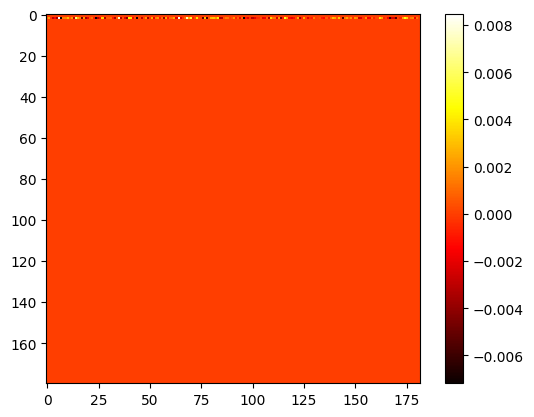

In [ ]:
#load txt
query = np.loadtxt("norm_out.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/ln_res_debug.txt")
np.savetxt("norm_out.txt", query, fmt='%.6f')
np.savetxt("./hls/ndt_calibrate/firmware/ln_res_debug.txt", hls_query, fmt='%.6f')
query = np.loadtxt("norm_out.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/ln_res_debug.txt")

#plot the difference between query and hls_query with heat map using matplotlib
import matplotlib.pyplot as plt
plt.imshow(query[540:720]-hls_query[540:720], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


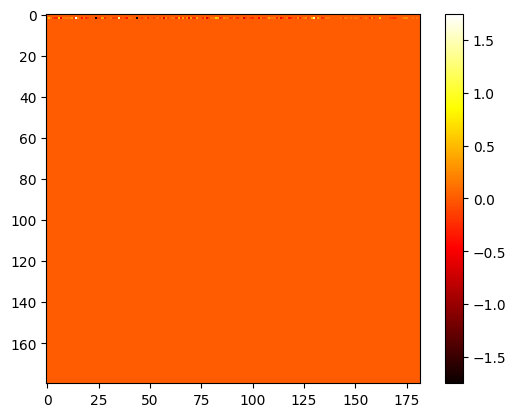

In [ ]:
#load txt
query = np.loadtxt("norm_in.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/ln_in_debug.txt")
np.savetxt("norm_in.txt", query, fmt='%.6f')
np.savetxt("./hls/ndt_calibrate/firmware/ln_in_debug.txt", hls_query, fmt='%.6f')
query = np.loadtxt("norm_in.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/ln_in_debug.txt")

#plot the difference between query and hls_query with heat map using matplotlib
import matplotlib.pyplot as plt
plt.imshow(query[540:720]-hls_query[540:720], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

(720, 182)
(720, 182)


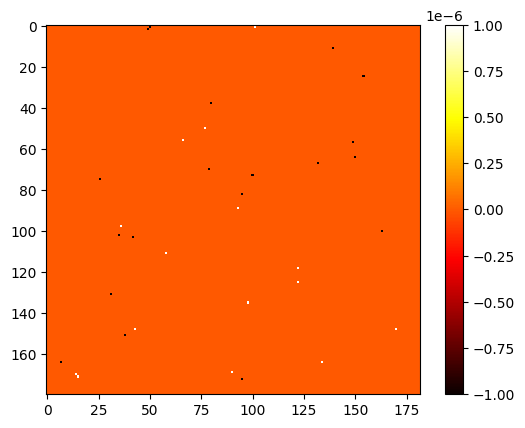

In [ ]:
#load txt
query = np.loadtxt("q.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/Q_debug.txt")
np.savetxt("q.txt", query, fmt='%.6f')
np.savetxt("./hls/ndt_calibrate/firmware/Q_debug.txt", hls_query, fmt='%.6f')
query = np.loadtxt("q.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/Q_debug.txt")
print(query.shape)
print(hls_query.shape)
#plot the difference between query and hls_query with heat map using matplotlib
import matplotlib.pyplot as plt
plt.imshow(query[0:180]-hls_query[0:180], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

(720, 182)
(720, 182)


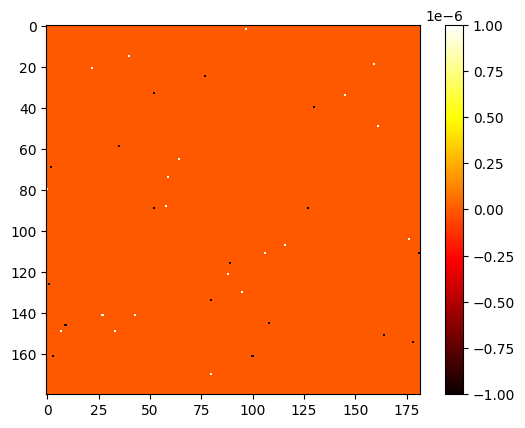

In [ ]:
#load txt
query = np.loadtxt("k.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/K_debug.txt")
np.savetxt("k.txt", query, fmt='%.6f')
np.savetxt("./hls/ndt_calibrate/firmware/K_debug.txt", hls_query, fmt='%.6f')
query = np.loadtxt("k.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/K_debug.txt")
print(query.shape)
print(hls_query.shape)
#plot the difference between query and hls_query with heat map using matplotlib
import matplotlib.pyplot as plt
plt.imshow(query[0:180]-hls_query[0:180], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

(720, 182)
(720, 182)


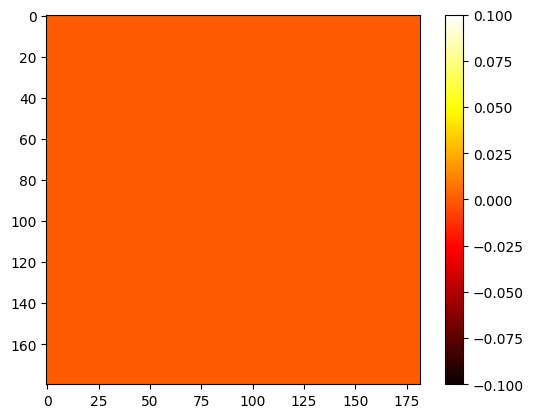

In [ ]:
#load txt
query = np.loadtxt("query.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/data_debug.txt")
np.savetxt("query.txt", query, fmt='%.6f')
np.savetxt("./hls/ndt_calibrate/firmware/data_debug.txt", hls_query, fmt='%.6f')
query = np.loadtxt("query.txt")
hls_query = np.loadtxt("./hls/ndt_calibrate/firmware/data_debug.txt")
print(query.shape)
print(hls_query.shape)
#plot the difference between query and hls_query with heat map using matplotlib
import matplotlib.pyplot as plt
plt.imshow(query[0:180]-hls_query[0:180], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
pprint(config)

In [ ]:
pprint(transformer_quant_config)


{0: {'ffn': {'in_proj': {'bias': {'bitwidth': 18, 'int_bitwidth': 2},
                         'input': {'bitwidth': 18,
                                   'int_bitwidth': -inf,
                                   'quantize': False},
                         'output': {'bitwidth': 18,
                                    'int_bitwidth': -inf,
                                    'quantize': False},
                         'weight': {'bitwidth': 18, 'int_bitwidth': 5}},
             'out_proj': {'bias': {'bitwidth': 18, 'int_bitwidth': 3},
                          'input': {'bitwidth': 18, 'int_bitwidth': 5},
                          'output': {'bitwidth': 18, 'int_bitwidth': 9},
                          'weight': {'bitwidth': 18, 'int_bitwidth': 5}}},
     'input': {'bitwidth': 18, 'int_bitwidth': 8},
     'norm1': {'bias': {'bitwidth': 18, 'int_bitwidth': 1},
               'input': {'bitwidth': 18, 'int_bitwidth': 6},
               'mean': {'bitwidth': 18, 'int_bitwidth': 1},
     

In [ ]:
assert False
print('test')

In [ ]:
qmodel = QTransformerEncoder([QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[0], calibration=False, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[1], calibration=False, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[2], calibration=False, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[3], calibration=False, device='cpu')], 
                             4, 
                             QLayerNorm(182, quant_config=transformer_quant_config['norm'], calibration=False, device='cpu'),
                             TorchQuantizer(bitwidth=18, int_bitwidth=6, signed=True, calibration=False, rounding='TRUNCATE', saturation='SAT'),
                             dtype=torch.float64)
qmodel.transfer_weights(model)
qmodel.to(torch.device('cpu'))
batch = 10
model.to(torch.device('cpu'))
model.eval()
with torch.no_grad():
    x = model.embedder(src[0:batch].permute(1, 0, 2)) * model.scale
    x = model.pos_encoder(x)
    qmodel.eval()
    qy = qmodel(x.type(torch.float64).to(torch.device('cpu')), mask=model._get_or_generate_context_mask(x))
    #print(qy)
    print(x.shape)
    y = model.transformer_encoder(x, mask=model._get_or_generate_context_mask(x))
    #print(y)
    pred_rates = model.decoder(qy.type(torch.float32)).permute(1, 0, 2) # t x b x n
    loss = model.classifier(pred_rates, mask_labels[0:batch])
    torch_masked_loss = loss[mask_labels[0:batch] != -100]
    torch_masked_loss = torch_masked_loss.mean()
    print(torch_masked_loss)
    print(bits_per_spike(pred_rates[:,:140,137:182].cpu().numpy(), spikes_heldout[0:batch,:,:].cpu().numpy()))

In [ ]:
#test time in cpu
qmodel = QTransformerEncoder([QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[0], calibration=False, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[1], calibration=False, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[2], calibration=False, device='cpu'),
                              QTransformerEncoderLayer(182, 2, 128, quant_config=transformer_quant_config[3], calibration=False, device='cpu')], 
                             4, 
                             QLayerNorm(182, quant_config=transformer_quant_config['norm'], calibration=False, device='cpu'),
                             TorchQuantizer(bitwidth=18, int_bitwidth=6, signed=True, calibration=False, rounding='TRUNCATE', saturation='SAT'),
                             dtype=torch.float64)
qmodel.transfer_weights(model)
qmodel.to(torch.device('cpu'))
batch = 547
model.to(torch.device('cpu'))
model.eval()
with torch.no_grad():
    x = model.embedder(src[0:batch].permute(1, 0, 2).to(torch.device('cpu'))) * model.scale
    x = model.pos_encoder(x)
    qmodel.eval()
    qy = qmodel(x.type(torch.float64).to(torch.device('cpu')), mask=model._get_or_generate_context_mask(x))
    print(qy)
    print(x.shape)
    y = model.transformer_encoder(x, mask=model._get_or_generate_context_mask(x))
    print(y)
    pred_rates = model.decoder(qy.type(torch.float32)).permute(1, 0, 2) # t x b x n
    loss = model.classifier(pred_rates, mask_labels[0:batch])
    torch_masked_loss = loss[mask_labels[0:batch] != -100]
    torch_masked_loss = torch_masked_loss.mean()
    print(torch_masked_loss)
    print(bits_per_spike(pred_rates[:,:140,137:182].cpu().numpy(), spikes_heldout[0:batch,:,:].cpu().numpy()))